# Initial Analysis

In this document, we aim to collate all the cleaned data to get an overview of our datasets. We'll be exploring statistics for the datasets in order to get an understanding of how they are structured, the distribution of the data and the contrast/similarities between the games and movie datasets

In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import plt
import seaborn as sns
from pathlib import Path

In [2]:
#The minimum accepted number for a franchise:
minimum_franchise_count = 3

In [3]:
#Specifications for the graphs
plot_title_size = 30
subplot_title_size = 25
axis_label_size = 22
tick_label_size = 15

In [4]:
# We get a lot of columns, this causes it to show all of them:
pd.set_option("display.max_columns", None)

In [5]:
movies_df = pd.read_csv("clean_data\clean_movies_with_franchises.csv", index_col = 0)
games_df = pd.read_csv("clean_data\clean_games_with_franchises.csv", index_col = 0)

D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
movies_df.sample()

,franchise_id,franchise_name,movie_name,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
NaN,NaN,NaN,NaN,tt0093142,Hangmen,0.0,1987.0,90,"Action,Adventure,Thriller",2.8,1155.0


In [7]:
games_df.sample()

,franchise_name,franchise_id,tconst,titleType,primaryTitle,startYear,isAdult,averageRating,numVotes,game_id,best_fit_ratio,genres,developers,platforms,publishers,rating
10250,NaN,NaN,tt19778382,videoGame,The Battle for Wesnoth,2003,0,8.8,5.0,NaN,85.5,['Fantasy'],NaN,NaN,NaN,NaN


We'll create a naming convention, renaming columns to standardise the column names. We'll also drop any unnecessary columns

In [8]:
games_df = games_df.rename(columns = {"titleType": "type", "rating": "age_rating", "startYear": "year", "primaryTitle": "title", "averageRating": "rating", "numVotes": "votes", "isAdult" : "is_adult"})
games_df = games_df.drop(["game_id", "best_fit_ratio"], axis = 1)
movies_df = movies_df.rename(columns={"startYear": "year", "primaryTitle": "title", "isAdult" : "is_adult", "runtimeMinutes": "runtime", "averageRating": "rating", "numVotes": "votes"})
movies_df = movies_df[["franchise_name", "franchise_id", "tconst", "title", "year", "is_adult", "runtime", "genres", "rating", "votes"]]

We clean up the genres column in games

In [9]:
games_df.genres = games_df.genres.apply(lambda x: x.strip("[]").split(","))
games_df.genres = games_df.genres.apply(lambda x: [i.strip(" '") for i in x])
games_df.genres = games_df.genres.apply(lambda x: ', '.join(x))

Rename the type of release so it's easy to make a distinction.

In [10]:
movies_df["type"] = "movie"
games_df["type"] = "game"

Combine the dataframes into a single dataframe

In [11]:
complete_df = pd.concat([movies_df, games_df])
complete_df = complete_df.reset_index(drop = True)

## Working with the combined dataset

Remove non-numerical years from data and convert to int

In [12]:
def convert_years(year):
    if type(year) == str:
        if year == "\\N":
            return 0
        else:
            return int(year)
    else:
        return int(year)

In [13]:
complete_df["year"] = complete_df["year"].apply(lambda x : convert_years(x))
complete_df = complete_df.loc[(complete_df['year'] > 1800) & (complete_df['year'] < 2024)]

We'll create a number_of_releases column which contains the number of releases in each franchise.

In [14]:
complete_df['number_of_releases'] = complete_df['franchise_id'].map(complete_df['franchise_id'].value_counts())

Get total number of franchises:

In [15]:
print("Total movie franchises: ", complete_df[complete_df["type"] == "movie"].franchise_id.nunique())
print("Total game franchises: ", complete_df[complete_df["type"] == "game"].franchise_id.nunique())

Total movie franchises:  1142
Total game franchises:  2081


We want to remove any movie or game franchises where the total franchise count is below the minimum permitted. This could have happened due to rapidfuzz being unable to match all the entries. We want to ensure we can still get as accurate a picture of how franchises work.

In [16]:
complete_df[["franchise_id", "franchise_name", "number_of_releases"]] = complete_df[["franchise_id", "franchise_name", "number_of_releases"]].apply(lambda x: np.nan if x["number_of_releases"] < minimum_franchise_count else x, axis=1)

We can see how this has affected the total number of franchises:

In [17]:
print("Total movie franchises: ", complete_df[complete_df["type"] == "movie"].franchise_id.nunique())
print("Total game franchises: ", complete_df[complete_df["type"] == "game"].franchise_id.nunique())

Total movie franchises:  845
Total game franchises:  1166


Normalise the genres format turning them all into lists:

In [18]:
def string_to_list(x):
    if x == '\\N':
        return []
    else:
        return x.split(',')

In [19]:
complete_df["genres"] = complete_df["genres"].apply(lambda x: string_to_list(x))

In [20]:
complete_df

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases
0,The Aldrich Family,f0,tt0032123,What a Life,1939,0.0,75,"[Comedy, Drama]",6.9,93.0,movie,NaN,NaN,NaN,NaN,11.0
1,The Aldrich Family,f0,tt0033834,Life with Henry,1940,0.0,80,"[Comedy, Family, Music]",6.0,49.0,movie,NaN,NaN,NaN,NaN,11.0
2,The Aldrich Family,f0,tt0033708,Henry Aldrich for President,1941,0.0,75,"[Comedy, Family]",6.6,146.0,movie,NaN,NaN,NaN,NaN,11.0
3,The Aldrich Family,f0,tt0034842,"Henry Aldrich, Editor",1942,0.0,72,"[Comedy, Drama, Family]",6.4,150.0,movie,NaN,NaN,NaN,NaN,11.0
4,The Aldrich Family,f0,tt0034844,Henry and Dizzy,1942,0.0,71,"[Comedy, Family]",7.2,58.0,movie,NaN,NaN,NaN,NaN,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307268,NaN,NaN,tt9888864,Infernal,2007,0.0,NaN,[Action],6.0,17.0,game,NaN,NaN,NaN,NaN,NaN
307269,NaN,NaN,tt9892552,Spiral Splatter,2017,0.0,NaN,[Action],2.0,10.0,game,NaN,NaN,NaN,NaN,NaN
307270,NaN,NaN,tt9893348,Alien: Covenant In Utero VR Experience,2017,0.0,NaN,[Sci-Fi],6.0,17.0,game,NaN,NaN,NaN,NaN,NaN
307271,LEGO,3025-448,tt9893804,The Lego Movie 2 Videogame,2019,0.0,NaN,"[Animation, Family, Adventure, Action-Adven...",5.5,161.0,game,['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN,57.0


## Initial Analysis on Complete Dataframe:

We can see the distribution of franchise vs non-franchise information:

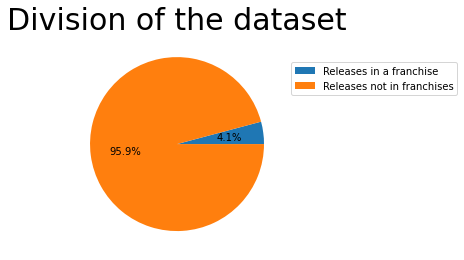

In [21]:
pie = plt.pie([complete_df[~complete_df["franchise_id"].isna()].tconst.nunique(), complete_df[complete_df["franchise_id"].isna()].tconst.nunique()], autopct='%1.1f%%')
plt.legend(pie[0], ["Releases in a franchise", "Releases not in franchises"], bbox_to_anchor=(1,0.9))
plt.title("Division of the dataset", fontsize = plot_title_size)

plt.show()

And this can be broken down further into movies and games:

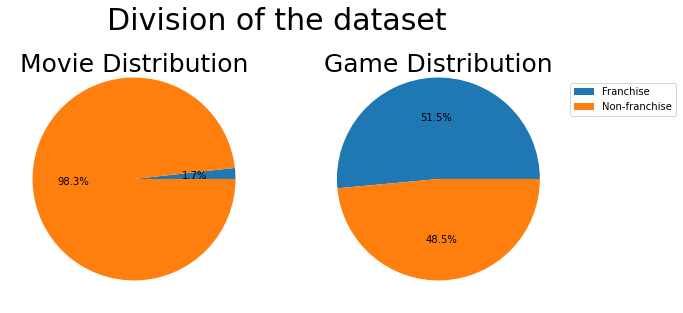

In [22]:
import matplotlib.pyplot as plt

movie_franchise_count = complete_df[(complete_df["type"] == "movie") & (~complete_df["franchise_id"].isna())]["tconst"].nunique()
movie_non_franchise_count = complete_df[(complete_df["type"] == "movie") & (complete_df["franchise_id"].isna())]["tconst"].nunique()

game_franchise_count = complete_df[(complete_df["type"] == "game") & (~complete_df["franchise_id"].isna())]["tconst"].nunique()
game_non_franchise_count = complete_df[(complete_df["type"] == "game") & (complete_df["franchise_id"].isna())]["tconst"].nunique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie([movie_franchise_count, movie_non_franchise_count], autopct='%1.1f%%')
ax1.legend('', frameon=False)
ax1.set_title("Movie Distribution",  fontsize = subplot_title_size, y= 0.9)

ax2.pie([game_franchise_count, game_non_franchise_count], autopct='%1.1f%%')
ax2.legend(["Franchise", "Non-franchise"], bbox_to_anchor=(1, 0.9))
ax2.set_title("Game Distribution", fontsize = subplot_title_size, y=0.9)

plt.suptitle("Division of the dataset", fontsize = plot_title_size)
plt.show()


It's pretty clear that the bulk of our movies are not in a franchise whereas the games have closer to a 50/50 split between franchise vs non-franchise. For the purposes of the rest of our project, we will only be focusing on the franchised information, and will not be using the non-franchised information. However we'll save the dataframe to a csv so it's easy to do analysis comparing the two if needed.

In [24]:
dataset_dir = Path('final_dataframes')
dataset_dir.mkdir(exist_ok=True)

In [25]:
complete_df.to_csv("final_dataframes\\complete_dataset.csv")

In [26]:
#complete_df = pd.read_csv("final_dataframes\\complete_dataset.csv", index_col = 0)

## Organising the franchises

Now we will begin to add additional information that will help with further analysis. We won't be using the non-franchised information from this point on. The first thing we will do is to calculate the first and last year in each franchise and where in the franchise each entry sits.

In [26]:
complete_df.dropna(subset=["franchise_id"], inplace=True)

In [28]:
complete_df.head(20)

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases
0,The Aldrich Family,f0,tt0032123,What a Life,1939,0.0,75,"[Comedy, Drama]",6.9,93.0,movie,NaN,NaN,NaN,NaN,11.0
1,The Aldrich Family,f0,tt0033834,Life with Henry,1940,0.0,80,"[Comedy, Family, Music]",6.0,49.0,movie,NaN,NaN,NaN,NaN,11.0
2,The Aldrich Family,f0,tt0033708,Henry Aldrich for President,1941,0.0,75,"[Comedy, Family]",6.6,146.0,movie,NaN,NaN,NaN,NaN,11.0
3,The Aldrich Family,f0,tt0034842,"Henry Aldrich, Editor",1942,0.0,72,"[Comedy, Drama, Family]",6.4,150.0,movie,NaN,NaN,NaN,NaN,11.0
4,The Aldrich Family,f0,tt0034844,Henry and Dizzy,1942,0.0,71,"[Comedy, Family]",7.2,58.0,movie,NaN,NaN,NaN,NaN,11.0
5,The Aldrich Family,f0,tt0035985,Henry Aldrich Swings It,1943,0.0,64,"[Comedy, Family]",8.3,110.0,movie,NaN,NaN,NaN,NaN,11.0
6,The Aldrich Family,f0,tt0035983,Henry Aldrich Gets Glamour,1943,0.0,72,"[Adventure, Comedy, Family]",6.4,130.0,movie,NaN,NaN,NaN,NaN,11.0
7,The Aldrich Family,f0,tt0035984,Henry Aldrich Haunts a House,1943,0.0,73,"[Adventure, Comedy, Family]",6.3,151.0,movie,NaN,NaN,NaN,NaN,11.0
8,The Aldrich Family,f0,tt0036909,"Henry Aldrich, Boy Scout",1944,0.0,66,"[Comedy, Family]",6.5,129.0,movie,NaN,NaN,NaN,NaN,11.0
9,The Aldrich Family,f0,tt0036907,Henry Aldrich Plays Cupid,1944,0.0,65,"[Comedy, Family]",8.2,100.0,movie,NaN,NaN,NaN,NaN,11.0


In [45]:
complete_df = complete_df.groupby('franchise_id').agg(first_year=('year', 'min'), last_year=('year', 'max'), \
                                                      lowest_vote=('votes', 'min'), highest_vote=('votes', 'max'), \
                                                      lowest_rating=('rating', 'min'), highest_rating=('rating', 'max')) \
       .reset_index() \
       .merge(complete_df, on='franchise_id', how='right') \
       .assign(franchise_pos=lambda x: (x['year'] - x['first_year']) / (x['last_year'] - x['first_year']) * 100)

We'll also calculate the lowest rated year and its position in the franchise

In [46]:
minRat = complete_df.groupby('franchise_id')['rating'].idxmin()
maxRat = complete_df.groupby('franchise_id')['rating'].idxmax()
complete_df = complete_df.sort_values(["franchise_id", "year"])

# Select the year value at the index and assign it to a new column for every row with the same franchise_id
complete_df['lowest_rated_year'] = complete_df.loc[minRat, 'year'].values.repeat(complete_df.groupby('franchise_id').size())
complete_df['highest_rated_year'] = complete_df.loc[maxRat, 'year'].values.repeat(complete_df.groupby('franchise_id').size())
complete_df['lowest_rated_pos'] = complete_df.loc[minRat, 'franchise_pos'].values.repeat(complete_df.groupby('franchise_id').size())
complete_df['highest_rated_pos'] = complete_df.loc[maxRat, 'franchise_pos'].values.repeat(complete_df.groupby('franchise_id').size())

Now we'll calculate the average rating before and after the lowest rated year.

In [47]:
complete_df["pos_rel_to_lowest_year"] = complete_df.apply(lambda x: 'pre' if x['year'] < x['lowest_rated_year'] else ('post' if x['year'] > x['lowest_rated_year'] else 'lowest'), axis=1)
complete_df['avg_rating_pre_lowest_year'] = complete_df.groupby('franchise_id')['rating'].transform(lambda x: x.loc[complete_df['pos_rel_to_lowest_year'] == 'pre'].mean())
complete_df['avg_rating_post_lowest_year'] = complete_df.groupby('franchise_id')['rating'].transform(lambda x: x.loc[complete_df['pos_rel_to_lowest_year'] == 'post'].mean())

In [32]:
complete_df.sample()

,franchise_id,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_name,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases,franchise_pos,lowest_rated_year,highest_rated_year,lowest_rated_pos,highest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year
10232,3025-160,1986,2022,7.0,787.0,5.6,8.8,Dragon Quest,tt1999867,Dragon Quest Monsters: Joker 2,2010,0.0,NaN,"[Role-Playing, Family, Fantasy]",6.4,18.0,game,"['TOSE Co., Ltd.']",['Nintendo DS'],"['Square Enix', 'Nintendo']","['CERO: A', 'ESRB: E']",20.0,66.666667,2012,2004,72.222222,50.0,pre,7.753846,7.5


We can create a rolling mean for our data to get average rating over time, as well as getting the current number in the franchise over time.

In [48]:
complete_df['rolling_avg_rating'] = complete_df.groupby('franchise_id')['rating'].expanding().mean().reset_index(0, drop=True)
complete_df['current_num_in_fran'] = complete_df.groupby('franchise_id')['year'].rank(method='first', ascending=True)

In [67]:
complete_df

,franchise_id,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_name,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases,franchise_pos,lowest_rated_year,highest_rated_year,lowest_rated_pos,highest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran
6057,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0315808,Baseball,1978,0.0,NaN,"[Baseball, Sports, Family, Sport]",3.0,14.0,game,['Nintendo R&D1'],"['Game Boy', 'Game Boy Advance', 'Nintendo Ent...","['Nintendo', 'HAMSTER Corporation']",['ESRB: E'],197.0,0.000000,1994,1990,36.363636,27.272727,pre,6.357143,7.007042,3.000000,1.0
6059,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0355727,Major League Baseball,1980,0.0,NaN,"[Baseball, Sports, Family, Sport]",4.9,15.0,game,['Nintendo R&D1'],"['Game Boy', 'Game Boy Advance', 'Nintendo Ent...","['Nintendo', 'HAMSTER Corporation']",['ESRB: E'],197.0,4.545455,1994,1990,36.363636,27.272727,pre,6.357143,7.007042,3.950000,2.0
6011,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0176664,Donkey Kong,1981,0.0,NaN,"[Platformer, Action, Puzzle]",7.4,2039.0,game,['Nintendo EAD'],"['Game Boy', 'Nintendo 3DS eShop']",['Nintendo'],"['ESRB: E', 'CERO: A', 'PEGI: 3+']",197.0,6.818182,1994,1990,36.363636,27.272727,pre,6.357143,7.007042,5.100000,3.0
6018,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt0204287,Donkey Kong Junior,1982,0.0,NaN,"[Action, Family]",6.6,313.0,game,['Nintendo'],['DSiWare'],['Nintendo'],"['ESRB: E', 'OFLC: G']",197.0,9.090909,1994,1990,36.363636,27.272727,pre,6.357143,7.007042,5.475000,4.0
6174,3025-1,1978,2022,6.0,6633.0,1.9,9.2,Mario,tt3472820,Donkey Kong,1982,0.0,NaN,"[Platformer, Action, Family, Puzzle]",6.3,36.0,game,['Nintendo EAD'],"['Game Boy', 'Nintendo 3DS eShop']",['Nintendo'],"['ESRB: E', 'CERO: A', 'PEGI: 3+']",197.0,9.090909,1994,1990,36.363636,27.272727,pre,6.357143,7.007042,5.640000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,f994,1948,1950,99.0,658.0,6.0,7.0,Renato Castellani's Italian neorealism trilogy,tt0042060,You're My Everything,1950,0.0,94,"[Comedy, Musical]",6.0,180.0,movie,NaN,NaN,NaN,NaN,4.0,100.000000,1950,1950,100.000000,100.000000,lowest,6.900000,NaN,6.575000,4.0
3286,f995,1974,1987,2068.0,8301.0,2.7,5.8,It's Alive,tt0071198,The Bat People,1974,0.0,93,"[Horror, Romance]",2.7,2598.0,movie,NaN,NaN,NaN,NaN,4.0,0.000000,1974,1974,0.000000,0.000000,lowest,NaN,5.000000,2.700000,1.0
3287,f995,1974,1987,2068.0,8301.0,2.7,5.8,It's Alive,tt0071675,It's Alive,1974,0.0,91,"[Horror, Sci-Fi]",5.8,8301.0,movie,NaN,NaN,NaN,NaN,4.0,0.000000,1974,1974,0.000000,0.000000,lowest,NaN,5.000000,4.250000,2.0
3288,f995,1974,1987,2068.0,8301.0,2.7,5.8,It's Alive,tt0077756,It Lives Again,1978,0.0,91,"[Horror, Sci-Fi]",5.2,2494.0,movie,NaN,NaN,NaN,NaN,4.0,30.769231,1974,1974,0.000000,0.000000,post,NaN,5.000000,4.566667,3.0


## Splitting the data
At this stage we are going to create 3 separate dataframes. The first will be the one we currently have. This is where every item in each franchise has it's own row. The second dataframe will group all the franchises by year, and each unique year for each franchise will be a single entry. The final dataframe will group all the entries for each franchises into a single row to give an overview of the franchise as a whole.

### Dataframe 1:

This is already complete. We will save to a csv file for easy access later.

In [35]:
complete_df.to_csv("final_dataframes\\df_individual_entries.csv")

### Dataframe 2:

In this dataframe, we want to group all the franchises by year, to allow us to tackle the data in a different way:

In [51]:
merged_years_df = complete_df.copy(deep=True)

Get total for each year, for each franchise

In [52]:
merged_years_df['content_per_year'] = merged_years_df.groupby(["franchise_id", "year"])["year"].transform('count')

Create average votes and ratings for each franchise

In [53]:
grouped_movies = merged_years_df.groupby(["franchise_id", "year"]).agg({"votes": "mean", "rating": "mean"}).reset_index()
merged_years_df = pd.merge(merged_years_df, grouped_movies, on=["franchise_id", "year"], how="left", suffixes=(None, '_average'))

In [39]:
merged_years_df.sample()

,franchise_id,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_name,tconst,title,year,is_adult,runtime,genres,rating,votes,type,developers,platforms,publishers,age_rating,number_of_releases,franchise_pos,lowest_rated_year,highest_rated_year,lowest_rated_pos,highest_rated_pos,pos_rel_to_lowest_year,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran,content_per_year,votes_average,rating_average
4866,3025-334,1998,2018,10.0,2196.0,4.5,8.5,Spyro,tt0255614,Spyro 2: Ripto's Rage!,1999,0.0,NaN,"[Platformer, Action, Fantasy, Adventure]",8.5,1423.0,game,['Insomniac Games'],"['PlayStation', 'PlayStation Network (PS3)', '...",['Sony Interactive Entertainment America'],"['ESRB: E', 'PEGI: 7+']",16.0,5.0,2004,1999,30.0,5.0,pre,7.171429,7.228571,8.35,2.0,1,1423.0,8.5


In [54]:
# group by name and release year, aggregate the franchise_id lists
merged_years_df = merged_years_df.groupby(['franchise_id', 'year'], as_index=False).agg(({
    'franchise_name': 'first',
    'franchise_id': 'first',
    "type": "first",
    'tconst': ", ".join,
    'title': ", ".join,
    "year": 'first',
    "votes_average": "first", 
    "rating_average": "first", 
    "number_of_releases" : "first",
    "content_per_year": "first", 
    "first_year": "first",
    "last_year": "first",
    "lowest_vote": "first",
    "highest_vote" : "first",
    "lowest_rating" : "first",
    "highest_rating" : "first",
    "franchise_pos": "last",
    "lowest_rated_year" : "first",
    "lowest_rated_pos" : "first",
    "highest_rated_year" : "first",
    "highest_rated_pos" : "first",
    "avg_rating_pre_lowest_year": "first",
    "avg_rating_post_lowest_year": "first",
    "rolling_avg_rating": "last",
    "current_num_in_fran": "last"    
    
# Note that we are dropping these for simplicities sake: is_adult, runtime, genres, developers, platforms, publishers, age_rating
}))

Create columns that have the difference in year between the previous entries in the franchise, the difference in average vote count and average rating

In [41]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,votes_average,rating_average,number_of_releases,content_per_year,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_pos,lowest_rated_year,lowest_rated_pos,highest_rated_year,highest_rated_pos,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran
2796,Grandia,3025-264,game,tt0337630,Grandia Xtreme,2002,27.0,5.6,4.0,1,1997,2005,27.0,246.0,5.6,8.2,62.5,2002,62.5,1997,0.0,8.1,7.5,7.266667,3.0


In [55]:
merged_years_df = merged_years_df.sort_values(["franchise_id", "year"])
merged_years_df['year_diff'] = merged_years_df.groupby(['franchise_id'])['year'].diff()
merged_years_df['vote_diff'] = merged_years_df.groupby(['franchise_id'])['votes_average'].diff()
merged_years_df['rating_diff'] = merged_years_df.groupby(['franchise_id'])['rating_average'].diff()
merged_years_df['num_of_releases_diff'] = merged_years_df.groupby(['franchise_id'])['content_per_year'].diff()
merged_years_df["running_length_years"] = merged_years_df['last_year'] - merged_years_df['first_year'] + 1

We'll also calculate how the ratings change relative to the rolling mean. To do this we first get the difference between the rolling average each year. We can then compare the rating for each year to the rolling average of the previous year (so that the value does not affect the average), by adding this to our rolling average for the current year:

In [56]:
merged_years_df['diff_from_prev_rar']= merged_years_df.groupby('franchise_id')['rolling_avg_rating'].diff()
merged_years_df['change_rel_to_rar'] = merged_years_df.apply(lambda x: x['rating_average'] - x['rolling_avg_rating'] + x['diff_from_prev_rar'], axis =1)

In [57]:
merged_years_df['change_rel_to_rar'] = merged_years_df['change_rel_to_rar'].fillna(0)
idx = merged_years_df.groupby('franchise_id')['change_rel_to_rar'].idxmin()

merged_years_df['year_biggest_drop'] = merged_years_df.loc[idx, 'year'].values.repeat(merged_years_df.groupby('franchise_id').size())
merged_years_df['pos_biggest_drop'] = merged_years_df.loc[idx, 'franchise_pos'].values.repeat(merged_years_df.groupby('franchise_id').size())

In [58]:
merged_years_df["pos_rel_to_drop"] = merged_years_df.apply(lambda x: 'pre' if x['year'] < x['year_biggest_drop'] else ('post' if x['year'] > x['year_biggest_drop'] else 'lowest'), axis=1)
merged_years_df['avg_rating_pre_drop'] = merged_years_df.groupby('franchise_id')['rating_average'].transform(lambda x: x.loc[merged_years_df['pos_rel_to_drop'] == 'pre'].mean())
merged_years_df['avg_rating_post_drop'] = merged_years_df.groupby('franchise_id')['rating_average'].transform(lambda x: x.loc[merged_years_df['pos_rel_to_drop'] == 'post'].mean())

In [59]:
merged_years_df = merged_years_df.drop('pos_rel_to_drop', axis = 1)

In [47]:
merged_years_df

,franchise_name,franchise_id,type,tconst,title,year,votes_average,rating_average,number_of_releases,content_per_year,first_year,last_year,lowest_vote,highest_vote,lowest_rating,highest_rating,franchise_pos,lowest_rated_year,lowest_rated_pos,highest_rated_year,highest_rated_pos,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,rolling_avg_rating,current_num_in_fran,year_diff,vote_diff,rating_diff,num_of_releases_diff,running_length_years,diff_from_prev_rar,change_rel_to_rar,year_biggest_drop,pos_biggest_drop,avg_rating_pre_drop,avg_rating_post_drop
0,Mario,3025-1,game,tt0315808,Baseball,1978,14.000000,3.000000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,0.000000,1994,36.363636,1990,27.272727,6.357143,7.007042,3.000000,1.0,NaN,NaN,NaN,NaN,45,NaN,0.000000,1994,36.363636,6.300222,7.086886
1,Mario,3025-1,game,tt0355727,Major League Baseball,1980,15.000000,4.900000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,4.545455,1994,36.363636,1990,27.272727,6.357143,7.007042,3.950000,2.0,2.0,1.000000,1.900000,0.0,45,0.950000,1.900000,1994,36.363636,6.300222,7.086886
2,Mario,3025-1,game,tt0176664,Donkey Kong,1981,2039.000000,7.400000,197.0,1,1978,2022,6.0,6633.0,1.9,9.2,6.818182,1994,36.363636,1990,27.272727,6.357143,7.007042,5.100000,3.0,1.0,2024.000000,2.500000,0.0,45,1.150000,3.450000,1994,36.363636,6.300222,7.086886
3,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,174.500000,6.450000,197.0,2,1978,2022,6.0,6633.0,1.9,9.2,9.090909,1994,36.363636,1990,27.272727,6.357143,7.007042,5.640000,5.0,1.0,-1864.500000,-0.950000,1.0,45,0.540000,1.350000,1994,36.363636,6.300222,7.086886
4,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,328.400000,6.020000,197.0,5,1978,2022,6.0,6633.0,1.9,9.2,11.363636,1994,36.363636,1990,27.272727,6.357143,7.007042,5.830000,10.0,1.0,153.900000,-0.430000,3.0,45,0.190000,0.380000,1994,36.363636,6.300222,7.086886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10975,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0038970,Sotto il sole di Roma,1948,311.000000,6.900000,4.0,1,1948,1950,99.0,658.0,6.0,7.0,0.000000,1950,100.000000,1950,100.000000,6.900000,NaN,6.900000,1.0,NaN,NaN,NaN,NaN,3,NaN,0.000000,1950,100.000000,6.900000,NaN
10976,Renato Castellani's Italian neorealism trilogy,f994,movie,"tt0040018, tt0044572, tt0042060","It's Forever Springtime, Two Cents Worth of Ho...",1950,312.333333,6.466667,4.0,3,1948,1950,99.0,658.0,6.0,7.0,100.000000,1950,100.000000,1950,100.000000,6.900000,NaN,6.575000,4.0,2.0,1.333333,-0.433333,2.0,3,-0.325000,-0.433333,1950,100.000000,6.900000,NaN
10977,It's Alive,f995,movie,"tt0071198, tt0071675","The Bat People, It's Alive",1974,5449.500000,4.250000,4.0,2,1974,1987,2068.0,8301.0,2.7,5.8,0.000000,1974,0.000000,1974,0.000000,NaN,5.000000,4.250000,2.0,NaN,NaN,NaN,NaN,14,NaN,0.000000,1974,0.000000,NaN,5.000000
10978,It's Alive,f995,movie,tt0077756,It Lives Again,1978,2494.000000,5.200000,4.0,1,1974,1987,2068.0,8301.0,2.7,5.8,30.769231,1974,0.000000,1974,0.000000,NaN,5.000000,4.566667,3.0,4.0,-2955.500000,0.950000,-1.0,14,0.316667,0.950000,1974,0.000000,NaN,5.000000


Finally, we can save the results to a csv.

In [48]:
merged_years_df.to_csv("final_dataframes\\df_merged_years.csv")

### Dataframe 3:

In this dataframe, we want to group all the franchises into a single entry per franchise.

In [60]:
franchise_grouped_df = merged_years_df.groupby('franchise_id').agg(    
    franchise_name = ('franchise_name', 'last'),
    running_length_years=('year', lambda x: (x.max() - x.min()) +1),
    releases_in_franchise=('number_of_releases', 'max'),
    first_year = ('first_year', 'first'),
    last_year = ('last_year', 'last'),
    release_gap_range = ('year_diff', lambda x: np.nanmax(x) - np.nanmin(x)),
    content_per_year = ('content_per_year', 'mean'),
    content_type = ('type', 'last'),
    average_rating = ('rating_average', 'mean'),
    lowest_rating = ('lowest_rating', 'first'),
    highest_rating = ('highest_rating', 'first'),
    avg_rating_pre_lowest_year = ('avg_rating_pre_lowest_year', 'last'),
    avg_rating_post_lowest_year = ('avg_rating_post_lowest_year', 'last'),
    average_votes = ('votes_average', 'mean'),
    lowest_votes = ('lowest_vote', 'first'),
    highest_votes = ('highest_vote', 'first'),
    lowest_rated_year = ('lowest_rated_year', 'last'),
    lowest_rated_pos = ('lowest_rated_pos', 'last'),
    avg_year_diff = ('year_diff', 'mean'),
    avg_vote_diff = ('vote_diff', 'mean'),
    avg_rating_diff = ('rating_diff', 'mean'),
    avg_num_of_releases_diff = ('num_of_releases_diff', 'mean'),
    biggest_drop = ('change_rel_to_rar', 'min'),
    year_biggest_drop = ('year_biggest_drop', 'first'),
    pos_biggest_drop = ('pos_biggest_drop', 'first'),
    avg_rating_pre_drop = ('avg_rating_pre_drop', 'first'),
    avg_rating_post_drop = ('avg_rating_post_drop', 'first')

)

<ipython-input-60-e04684f6c250>:7: RuntimeWarning: All-NaN axis encountered
  release_gap_range = ('year_diff', lambda x: np.nanmax(x) - np.nanmin(x)),


In [50]:
franchise_grouped_df.head(20)

,franchise_name,running_length_years,releases_in_franchise,first_year,last_year,release_gap_range,content_per_year,content_type,average_rating,lowest_rating,highest_rating,avg_rating_pre_lowest_year,avg_rating_post_lowest_year,average_votes,lowest_votes,highest_votes,lowest_rated_year,lowest_rated_pos,avg_year_diff,avg_vote_diff,avg_rating_diff,avg_num_of_releases_diff,biggest_drop,year_biggest_drop,pos_biggest_drop,avg_rating_pre_drop,avg_rating_post_drop
franchise_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
3025-1,Mario,45,197.0,1978,2022,1.0,4.477273,game,6.757640,1.9,9.2,6.357143,7.007042,735.716252,6.0,6633.0,1994,36.363636,1.023256,1.709302,0.097674,0.023256,-1.957143,1994,36.363636,6.300222,7.086886
3025-10,Tony Hawk,22,15.0,1999,2020,4.0,1.071429,game,6.671429,2.4,8.5,6.869231,8.500000,606.607143,17.0,1517.0,2015,76.190476,1.615385,-48.384615,0.053846,0.000000,-4.469231,2015,76.190476,6.875000,8.500000
3025-100,Commander Keen,12,8.0,1990,2001,9.0,2.666667,game,6.997222,6.7,7.8,7.185714,NaN,70.305556,31.0,126.0,2001,100.000000,5.500000,-32.833333,-0.083333,-1.000000,-0.485714,2001,100.000000,7.145833,NaN
3025-1000,Fate,22,10.0,2000,2021,4.0,1.000000,game,7.480000,7.1,8.1,7.600000,7.512500,52.900000,7.0,154.0,2005,23.809524,2.333333,-3.777778,-0.055556,0.000000,-0.500000,2005,23.809524,7.600000,7.512500
3025-1008,Winx Club,9,6.0,2006,2014,3.0,1.200000,game,7.580000,7.1,8.2,7.550000,8.200000,11.700000,5.0,48.0,2012,75.000000,2.000000,-6.125000,0.150000,-0.250000,-0.450000,2012,75.000000,7.533333,8.200000
3025-1009,NBA Jam,18,5.0,1993,2010,6.0,1.000000,game,7.120000,5.1,8.3,8.200000,7.050000,145.800000,53.0,385.0,1996,17.647059,4.250000,-60.250000,-0.250000,0.000000,-3.100000,1996,17.647059,8.200000,7.050000
3025-101,Commando,29,9.0,1983,2011,17.0,1.000000,game,6.377778,5.3,7.3,NaN,6.512500,70.888889,11.0,232.0,1983,0.000000,3.500000,-0.625000,0.050000,0.000000,-0.762500,2011,100.000000,6.462500,NaN
3025-1010,Overlord,3,4.0,2007,2009,0.0,2.000000,game,7.450000,7.0,8.1,7.700000,NaN,110.500000,8.0,260.0,2009,100.000000,2.000000,-49.000000,-0.500000,0.000000,-0.500000,2009,100.000000,7.700000,NaN
3025-1012,Two Worlds,5,3.0,2007,2011,2.0,1.000000,game,5.733333,5.0,6.6,6.100000,NaN,89.000000,6.0,132.0,2011,100.000000,2.000000,-61.500000,-0.300000,0.000000,-1.100000,2011,100.000000,6.100000,NaN


In [51]:
franchise_grouped_df.to_csv("final_dataframes\\df_franchise_grouped.csv")

Finally we'll get a sample of all the dataframes to use in our report

In [61]:
sample_df1 = complete_df[complete_df["franchise_name"]=="Tarzan (1918 series)"]
sample_df1 = sample_df1[['franchise_id', 'franchise_name','tconst', 'title', 'year', 'rating', 'votes', 'franchise_pos']]
sample_df1.to_latex('sample_df1.tex')

In [53]:
sample_df2 = merged_years_df[merged_years_df["franchise_name"]=="Tarzan (1918 series)"]
sample_df2 = sample_df2[['franchise_name', 'franchise_id', 'type', 'tconst', 'title', 'year', 'votes_average', 'rating_average', 'number_of_releases', 'content_per_year', 'rolling_avg_rating', 'change_rel_to_rar']]
sample_df2.to_latex('sample_df2.tex')

In [58]:
sample_df3 = franchise_grouped_df[(franchise_grouped_df.index == "f130") | (franchise_grouped_df.index == "f131") | (franchise_grouped_df.index == "f132") | (franchise_grouped_df.index == "f133")]
sample_df3 = sample_df3[['franchise_name','running_length_years','releases_in_franchise','first_year','last_year','release_gap_range','content_per_year','content_type','average_rating','lowest_rating','highest_rating']]
sample_df3.to_latex('sample_df3.tex')

In [ ]:
franchise_grouped_df.to_latex('mytable.tex')

## Initial Analysis

We can get a count for the number of franchises in our dataset, and how many of these are games vs movies

In [99]:
stats = pd.DataFrame(
    {
        "Total": [
            complete_df.franchise_id.nunique(),
            complete_df.loc[complete_df["type"] == "movie", "franchise_id"].nunique(),
            complete_df.loc[complete_df["type"] == "game", "franchise_id"].nunique(),
            complete_df.loc[complete_df["type"] == "movie", "tconst"].nunique(),
            complete_df.loc[complete_df["type"] == "game", "tconst"].nunique(),            
        ]
    },
    index=[
        "Franchises",
        "Movie franchises",
        "Game franchises",
        "Movies in a franchise",
        "Games in a franchise",
    ]
)
stats

,Total
Franchises,2011
Movie franchises,845
Game franchises,1166
Movies in a franchise,5036
Games in a franchise,7617


We'll also get statistics for our datasets overall:

In [75]:
movie_df = complete_df[complete_df['type']=='movie']
game_df = complete_df[complete_df['type']=='game']
movie_group_df = franchise_grouped_df[franchise_grouped_df['content_type']=='movie']
game_group_df = franchise_grouped_df[franchise_grouped_df['content_type']=='game']


In [76]:
df_stats = pd.DataFrame({'Movie Mean': movie_df.mean(), 'Game Mean': game_df.mean(), 'Movie Median': movie_df.median(), 'Game Median': game_df.median(), \
                        'Movie Min': movie_df.min(), 'Game Min': game_df.min(), 'Movie Max': movie_df.max(), 'Game Max': game_df.max()})
df_stats = df_franchise_stats.loc[['number_of_releases', 'rating', 'highest_rating', 'lowest_rating', 'votes', 'highest_vote', 'lowest_vote','year', 'highest_rated_year','lowest_rated_year']]
df_stats

D:\Programs\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Movie Mean,Game Mean,Movie Median,Game Median,Movie Min,Game Min,Movie Max,Game Max
number_of_releases,13.132592,31.407448,7.0,12.0,3,3,70,215
rating,6.023422,7.037222,6.1,7.2,1,1.3,9.2,9.7
highest_rating,7.016832,8.303010,7.1,8.4,1.7,3.1,9.2,9.7
lowest_rating,4.993390,5.011817,5.1,5.2,1,1.3,8.2,8.7
votes,45990.182017,590.866633,805.0,68.0,5,5,2.70053e+06,70811
highest_vote,99530.479158,3416.212380,5865.0,741.0,11,7,2.70053e+06,70811
lowest_vote,14022.102025,35.512028,137.0,10.0,5,5,1.49448e+06,10916
year,1977.135570,2003.967589,1979.0,2005.0,1914,1971,2023,2023
highest_rated_year,1974.479952,2002.734675,1976.0,2003.0,1914,1972,2023,2023
lowest_rated_year,1979.173085,2004.849421,1981.0,2007.0,1915,1974,2022,2023


In [81]:
df_franchise_stats = pd.DataFrame({'Movie Mean': movie_group_df.mean(), 'Game Mean': game_group_df.mean(), 'Movie Median': movie_group_df.median(), 'Game Median': game_group_df.median(), \
                        'Movie Min': movie_group_df.min(), 'Game Min': game_group_df.min(), 'Movie Max': movie_group_df.max(), 'Game Max': game_group_df.max()})
df_franchise_stats = df_franchise_stats.loc[['running_length_years', 'content_per_year', 'release_gap_range', 'average_rating', 'highest_rating', 'lowest_rating', 'average_votes', 'highest_votes', 'lowest_votes']]
df_franchise_stats

,Movie Mean,Game Mean,Movie Median,Game Median,Movie Min,Game Min,Movie Max,Game Max
running_length_years,12.711243,15.579760,9.00,13.500000,1,1,75,52
content_per_year,1.402232,1.202726,1.00,1.000000,1,1,10.3333,7.68182
release_gap_range,4.654172,5.100086,2.00,3.000000,0,0,46,38
average_rating,6.000070,7.059808,6.05,7.102861,1.6,2.575,8.6,9.25
highest_rating,6.847101,7.951630,7.00,8.000000,1.7,3.1,9.2,9.7
lowest_rating,5.141302,5.814322,5.30,6.000000,1,1.3,8.2,8.7
average_votes,52892.921658,521.729966,4067.00,100.583333,11,5.66667,1.97559e+06,30992.8
highest_votes,102996.595266,1577.350772,8699.00,223.500000,11,7,2.70053e+06,70811
lowest_votes,19233.953846,64.183533,443.00,13.000000,5,5,1.49448e+06,10916


<AxesSubplot:xlabel='franchise_pos', ylabel='rating'>

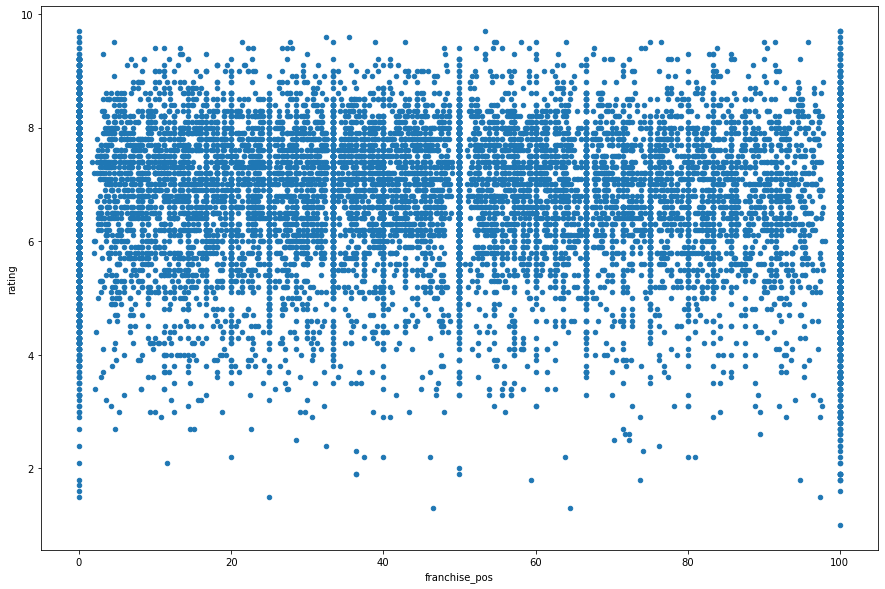

In [97]:
# Compare the ratings to the franchise position
complete_df.plot.scatter("franchise_pos", "rating", figsize = (15,10))

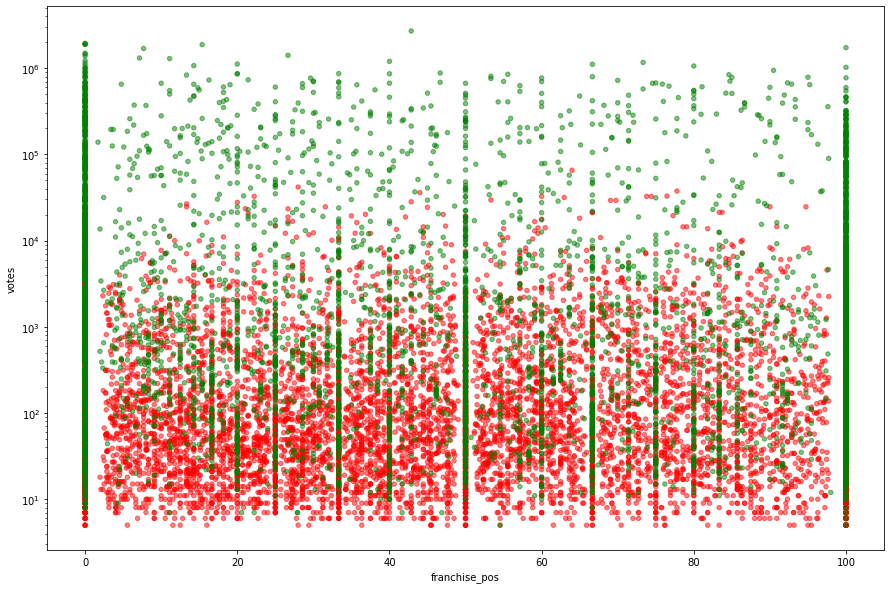

In [98]:
complete_df.plot.scatter("franchise_pos", "votes", c=complete_df['type'].map({'movie': 'green', 'game': 'red'}), alpha = 0.5, figsize = (15,10))
plt.yscale('log', base=10)